In [92]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Tratamento de Dados

In [3]:
# Definir tickers
tickers = {
    'SWTI': 'CL=F',  # WTI Crude Oil Spot Price
    'GAS': 'NG=F',   # Natural Gas prices
    'GOLD': 'GC=F',  # Price of Gold
    'SIL': 'SI=F',   # Price of Silver
    'SP500': '^GSPC' # S&P 500 Index
}

In [4]:
# Baixar os dados
data = yf.download(list(tickers.values()), start="1986-01-01", end="2024-06-15")

[*********************100%%**********************]  5 of 5 completed


In [5]:
# Renomear colunas para conveniência
data = data['Adj Close']
data.columns = list(tickers.keys())

In [6]:
print(data.head())

            SWTI  GAS  GOLD  SIL       SP500
Date                                        
1986-01-02   NaN  NaN   NaN  NaN  209.589996
1986-01-03   NaN  NaN   NaN  NaN  210.880005
1986-01-06   NaN  NaN   NaN  NaN  210.649994
1986-01-07   NaN  NaN   NaN  NaN  213.800003
1986-01-08   NaN  NaN   NaN  NaN  207.970001


In [7]:
# Drop rows with any NaN values
data = data.dropna()

In [8]:
print(data.head())

                 SWTI         GAS   GOLD    SIL        SP500
Date                                                        
2000-08-30  33.400002  273.899994  4.805  4.930  1502.589966
2000-08-31  33.099998  278.299988  4.780  5.003  1517.680054
2000-09-01  33.380001  277.000000  4.835  5.004  1520.770020
2000-09-05  33.799999  275.799988  4.960  4.998  1507.079956
2000-09-06  34.950001  274.200012  5.065  4.983  1492.250000


In [9]:
# Trocar colunas 'GAS' e 'GOLD'
data = data.rename(columns={'GAS': 'temp_GAS'})
data = data.rename(columns={'GOLD': 'GAS'})
data = data.rename(columns={'temp_GAS': 'GOLD'})

## Valores (2000 -> 2024)

In [10]:
print(data.head())

                 SWTI        GOLD    GAS    SIL        SP500
Date                                                        
2000-08-30  33.400002  273.899994  4.805  4.930  1502.589966
2000-08-31  33.099998  278.299988  4.780  5.003  1517.680054
2000-09-01  33.380001  277.000000  4.835  5.004  1520.770020
2000-09-05  33.799999  275.799988  4.960  4.998  1507.079956
2000-09-06  34.950001  274.200012  5.065  4.983  1492.250000


## Tamanho da Amostra e Dados Nulos

In [11]:
# Print the number of rows
print(f"Tamanho da amostra: {data.shape[0]} linhas")

Tamanho da amostra: 5965 linhas


In [12]:
from datetime import datetime

In [13]:
# Calculate the number of total days in the range
start_date = datetime.strptime("2000-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-06-01", "%Y-%m-%d")
total_days = (end_date - start_date).days + 1

# Calculate the number of days with data
days_with_data = data.shape[0]

# Calculate the number of days with missing data
days_with_missing_data = total_days - days_with_data

print(f"Total de dias no intervalo: {total_days}")
print(f"Dias com dados: {days_with_data}")
print(f"Dias com dados nulos: {days_with_missing_data}")

Total de dias no intervalo: 8919
Dias com dados: 5965
Dias com dados nulos: 2954


temos muitos dias c/ dados nulos devido aos fins-de-semana e feriados onde a bolsa está encerrada, ou seja, se calcularmos 2*52*(2024-2000) vai dar sensivelmente o valor de dados nulos

## Gráfico do WTI

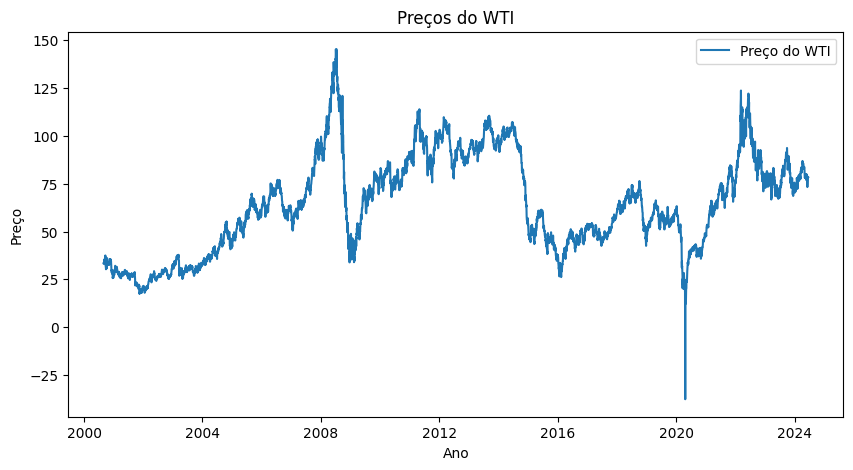

In [14]:
# Plotar o gráfico dos preços do WTI
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['SWTI'], label='Preço do WTI')
plt.title('Preços do WTI')
plt.xlabel('Ano')
plt.ylabel('Preço')
plt.legend()
plt.show()

em 2020 atinge preços negativos devido à pandemia, em que a produção não pára e devido ao excesso de stock, os produtores pagam aos compradores para ficarem com os seus barris de petróleo

## Gráfico WTI vs S&P500

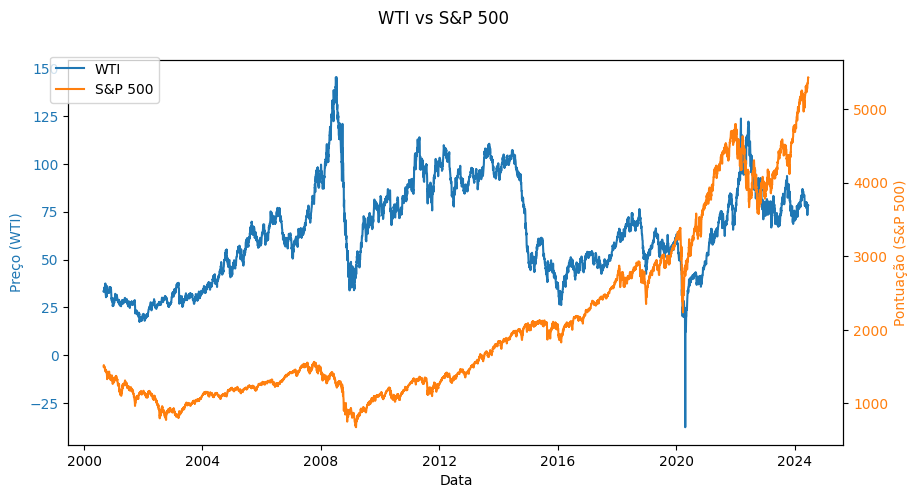

In [15]:
# Plotar gráfico do WTI e do S&P500
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot do WTI em azul no eixo y à esquerda
ax1.plot(data.index, data['SWTI'], label='WTI', color='tab:blue')
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço (WTI)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Criação de um segundo eixo y que compartilha o mesmo eixo x
ax2 = ax1.twinx()
ax2.plot(data.index, data['SP500'], label='S&P 500', color='tab:orange')
ax2.set_ylabel('Pontuação (S&P 500)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Título e legenda
fig.suptitle('WTI vs S&P 500')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.show()

## Gráfico com todas as commodities

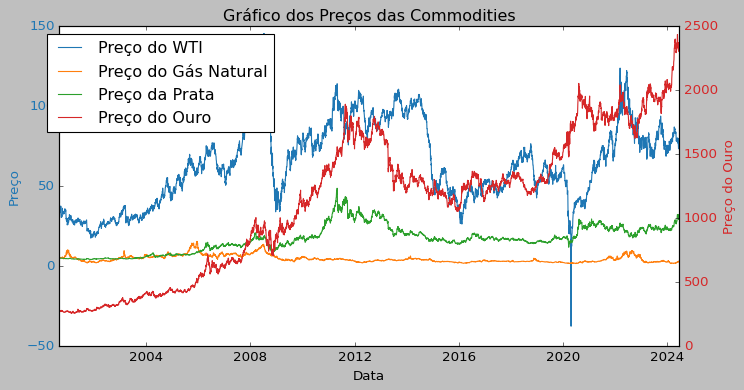

In [16]:
# Plotar o gráfico com as 4 variáveis
plt.style.use('classic')
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data.index, data['SWTI'], label='Preço do WTI', color='tab:blue')
ax1.plot(data.index, data['GAS'], label='Preço do Gás Natural', color='tab:orange')
ax1.plot(data.index, data['SIL'], label='Preço da Prata', color='tab:green')
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(data.index, data['GOLD'], label='Preço do Ouro', color='tab:red')
ax2.set_ylabel('Preço do Ouro', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Gráfico dos Preços das Commodities')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

# Matriz de Correlação (HeatMap)

In [17]:
# Calcular a matriz de correlação
correlation_matrix = data.corr()

In [22]:
import seaborn as sns

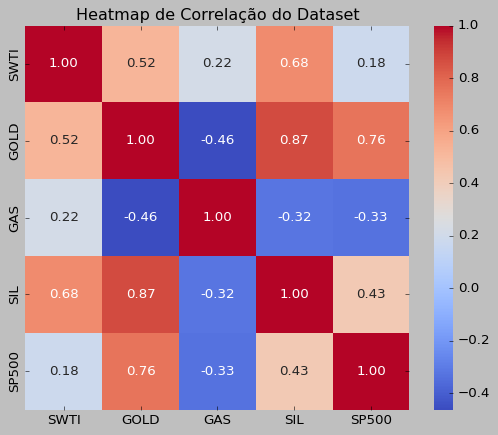

In [23]:
# Plotar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Heatmap de Correlação do Dataset')
plt.show()

# Describre das variáveis

In [25]:
from tabulate import tabulate

In [26]:
# Calcular as estatísticas descritivas
description = data.describe()

In [27]:
# Exibir a tabela formatada com tabulate
print(tabulate(description, headers='keys', tablefmt='psql'))

+-------+-----------+----------+------------+------------+---------+
|       |      SWTI |     GOLD |        GAS |        SIL |   SP500 |
|-------+-----------+----------+------------+------------+---------|
| count | 5965      | 5965     | 5965       | 5965       | 5965    |
| mean  |   64.4999 | 1129.49  |    4.46818 |   16.7487  | 2050.62 |
| std   |   25.3098 |  546.723 |    2.24826 |    8.34845 | 1145.7  |
| min   |  -37.63   |  255.1   |    1.482   |    4.026   |  676.53 |
| 25%   |   45.33   |  624.1   |    2.797   |   11.137   | 1191.03 |
| 50%   |   63.08   | 1226.3   |    3.83    |   16.621   | 1486.3  |
| 75%   |   83.45   | 1576     |    5.645   |   22.228   | 2713.83 |
| max   |  145.29   | 2433.9   |   15.378   |   48.584   | 5433.74 |
+-------+-----------+----------+------------+------------+---------+


In [28]:
# Formatar os rótulos das linhas em negrito
for label in description.index:
    description.rename(index={label: f'\033[1m{label}\033[0m'}, inplace=True)

# Adicionar os nomes das variáveis como rótulos de coluna
headers = ['SWTI', 'GOLD', 'GAS', 'SIL', 'SP500']

# Exibir a tabela formatada com tabulate
print(tabulate(description, headers=headers, tablefmt='psql'))

+-------+-----------+----------+------------+------------+---------+
|       |      SWTI |     GOLD |        GAS |        SIL |   SP500 |
|-------+-----------+----------+------------+------------+---------|
| count | 5965      | 5965     | 5965       | 5965       | 5965    |
| mean  |   64.4999 | 1129.49  |    4.46818 |   16.7487  | 2050.62 |
| std   |   25.3098 |  546.723 |    2.24826 |    8.34845 | 1145.7  |
| min   |  -37.63   |  255.1   |    1.482   |    4.026   |  676.53 |
| 25%   |   45.33   |  624.1   |    2.797   |   11.137   | 1191.03 |
| 50%   |   63.08   | 1226.3   |    3.83    |   16.621   | 1486.3  |
| 75%   |   83.45   | 1576     |    5.645   |   22.228   | 2713.83 |
| max   |  145.29   | 2433.9   |   15.378   |   48.584   | 5433.74 |
+-------+-----------+----------+------------+------------+---------+


# Modelagem

## Definir a window_size e o test_size

In [29]:
# Definir variáveis independentes e dependente
X = data[['GAS', 'GOLD', 'SIL', 'SP500']]
y = data['SWTI']

In [152]:
# Preparar os dados com janela deslizante
def prepare_data_with_window(data, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data.iloc[i:i+window_size, :-1].values.flatten())
        y_windows.append(data.iloc[i+window_size, -1])
    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows)
    return X_windows, y_windows

In [153]:
# Definir o tamanho da janela e a proporção do teste
window_size = 5
test_size = 0.3

In [212]:
# Preparar os dados com janela deslizante
X_windows, y_windows = prepare_data_with_window(pd.concat([X, y], axis=1), window_size)

In [219]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=test_size, random_state=42, shuffle=False)

# shuffle and keep order
train_inds = np.arange(X_train.shape[0])
np.random.shuffle(train_inds)

train_inds_recover = np.argsort(train_inds)

#X_train = X_train[train_inds]
#y_train = y_train[train_inds]


In [220]:
train_inds

array([2805, 1193, 3071, ..., 3137, 3903, 1832])

In [221]:
# Escalar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1,1)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

y_train = y_train.reshape(-1)

## Modelos ML

In [222]:
# Modelos de ML
models = {
    'SVR_RBF': SVR(kernel='rbf'),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

## Métricas usadas

In [223]:
# Obter previsões de cada modelo e calcular métricas
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_hat = scaler_y.inverse_transform(y_pred.reshape(-1,1))
    
    r2 = r2_score(y_test, y_hat)
    rmse = root_mean_squared_error(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)
    mape = mean_absolute_percentage_error(y_test, y_hat)
    results[name] = {
        'y_test': y_test,
        'y_pred': y_hat,
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'mape': mape
    }

In [224]:
# Exibir métricas
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"R²: {metrics['r2']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"MAPE: {metrics['mape']:.4f}")
    print("\n")

Model: SVR_RBF
R²: -0.0764
RMSE: 19.1704
MSE: 367.5048
MAPE: 0.2324


Model: Lasso
R²: -0.0149
RMSE: 18.6146
MSE: 346.5045
MAPE: 0.2607


Model: Ridge
R²: -0.0191
RMSE: 18.6533
MSE: 347.9474
MAPE: 0.2853




# Resultados

In [225]:
# Função para plotar os gráficos
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_test)), y_test, label='TRUE', color='blue')
    plt.plot(range(len(y_pred)), y_pred, label=model_name, color='orange')
    plt.title(f'Prediction results of crude oil spot prices by the {model_name} model')
    plt.xlabel('Observations')
    plt.ylabel('SWTI ($)')
    plt.legend()
    plt.show()

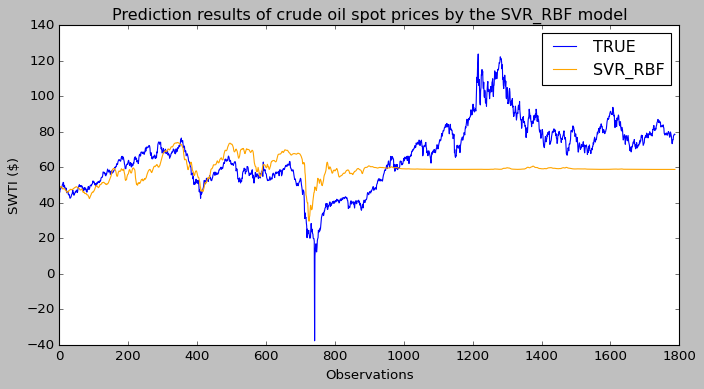

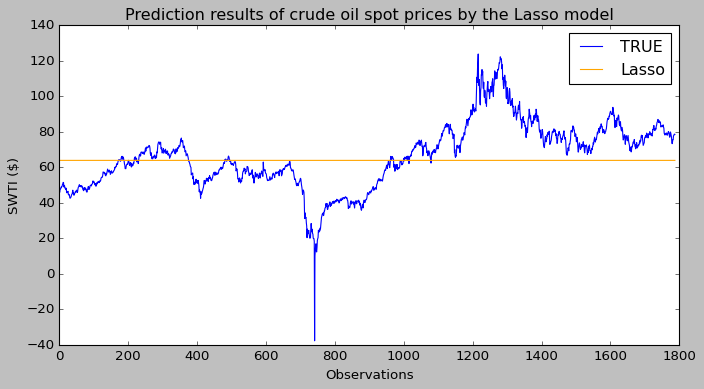

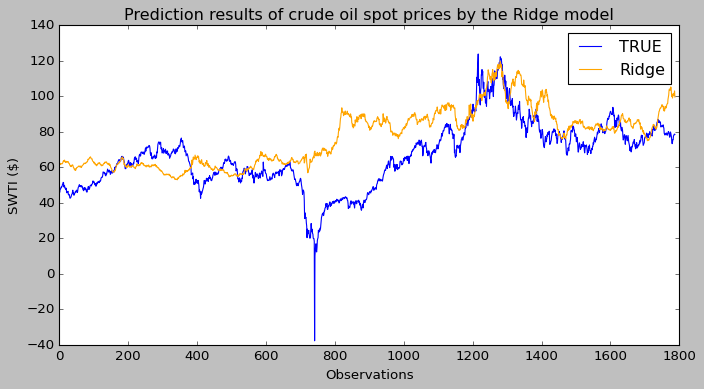

In [226]:
# Plotar os gráficos para cada modelo
for name, metrics in results.items():
    plot_predictions(metrics['y_test'], metrics['y_pred'], name)